In [2]:
import tensorflow as tf
# tf.get_logger().setLevel('INFO')
from functools import partial
import matplotlib.pyplot as plt
import IPython.display as display

2022-03-31 00:17:01.081853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/openvino_2020.1.023/opencv/lib:/opt/intel/openvino_2020.1.023/deployment_tools/ngraph/lib:/opt/intel/opencl:/opt/intel/openvino_2020.1.023/deployment_tools/inference_engine/external/hddl/lib:/opt/intel/openvino_2020.1.023/deployment_tools/inference_engine/external/gna/lib:/opt/intel/openvino_2020.1.023/deployment_tools/inference_engine/external/mkltiny_lnx/lib:/opt/intel/openvino_2020.1.023/deployment_tools/inference_engine/external/tbb/lib:/opt/intel/openvino_2020.1.023/deployment_tools/inference_engine/lib/intel64:
2022-03-31 00:17:01.081892: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


# Load the data

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
# IMAGE_SIZE = [1024, 1024]

In [5]:


FILENAMES_PATH = "American Sign Language Letters.v1-v1.tfrecord/"

TRAINING_FILENAMES =  FILENAMES_PATH + "train/Letters.tfrecord"
VALID_FILENAMES = FILENAMES_PATH + "valid/Letters.tfrecord"
TEST_FILENAMES = FILENAMES_PATH + "test/Letters.tfrecord"

print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 68
Validation TFRecord Files: 68
Test TFRecord Files: 67


In [6]:
example = TRAINING_FILENAMES
labeled = FILENAMES_PATH + "/train/Letters_label_map.pbtxt"

In [28]:
dataset = tf.data.TFRecordDataset(example)

# raw_example = next(iter(dataset))
# print(raw_example)
# parsed = tf.train.Example.FromString(raw_example.numpy())
# print(parsed)

# parsed.features.feature['image/text']

In [29]:
# for raw_record in dataset.take(10):
#     print(repr(raw_record))

In [30]:
tffeature_description = (
{
    "image/encoded": tf.io.FixedLenFeature([], tf.string),
    "image/filename": tf.io.FixedLenFeature([], tf.string),
    "image/format": tf.io.FixedLenFeature([], tf.string),
    "image/height": tf.io.FixedLenFeature([], tf.int64),
    "image/object/bbox/xmax": tf.io.FixedLenFeature([], tf.float32),
    "image/object/bbox/xmin": tf.io.FixedLenFeature([], tf.float32),
    "image/object/bbox/ymax": tf.io.FixedLenFeature([], tf.float32),
    "image/object/bbox/ymin": tf.io.FixedLenFeature([], tf.float32),
    "image/object/class/label": tf.io.FixedLenFeature([], tf.int64),
    "image/object/class/text": tf.io.FixedLenFeature([], tf.string),
    "image/width": tf.io.FixedLenFeature([], tf.int64),
}
)

def _parse_function(example):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    return tf.io.parse_single_example(example, tffeature_description)

In [31]:
# for parsed_record in parsed_dataset.take(1):
#     print(repr(parsed_record))

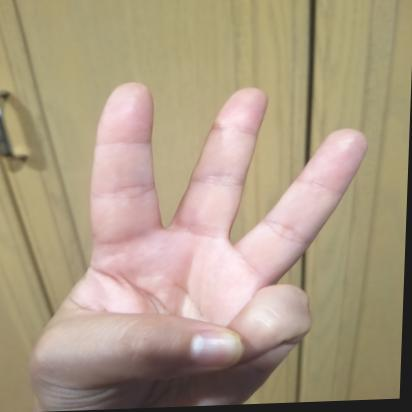

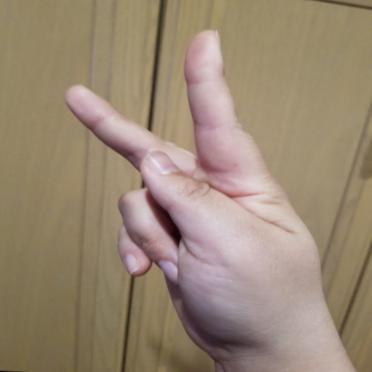

In [32]:
# parsed_dataset = dataset.map(_parse_function)
# parsed_dataset


parsed_img_list = []
for parsed in dataset.take(2):
    
    parsed_dataset = _parse_function(parsed)
    parsed_img_list.append(parsed_dataset)
    
IMAGE_SIZE = [300, 300]

for image_features in parsed_img_list:
    image_raw = image_features["image/encoded"].numpy()
  
    image_h = image_features["image/height"].numpy()
    image_w = image_features["image/width"].numpy()
#     print(image_h)
#     print(image_w)
#     print(image)
    display.display(display.Image(data=image_raw))

In [48]:
# Create the dataset object for tfrecord file(s)

def load_dataset(tf_filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(tf_filenames) 
    
    dataset = dataset.with_options(ignore_order)  
    
    return dataset

In [56]:
def decode_image(image,IMAGE_SIZE):
    image =  tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
    return image

In [57]:
# Decoding function
def parse_record(record):
    tfrecord_feat_format = (
                {
                    "image/encoded": tf.io.FixedLenFeature([], tf.string),
                    "image/filename": tf.io.FixedLenFeature([], tf.string),
                    "image/format": tf.io.FixedLenFeature([], tf.string),
                    "image/height": tf.io.FixedLenFeature([], tf.int64),
                    "image/object/bbox/xmax": tf.io.FixedLenFeature([], tf.float32),
                    "image/object/bbox/xmin": tf.io.FixedLenFeature([], tf.float32),
                    "image/object/bbox/ymax": tf.io.FixedLenFeature([], tf.float32),
                    "image/object/bbox/ymin": tf.io.FixedLenFeature([], tf.float32),
                    "image/object/class/label": tf.io.FixedLenFeature([], tf.int64),
                    "image/object/class/text": tf.io.FixedLenFeature([], tf.string),
                    "image/width": tf.io.FixedLenFeature([], tf.int64),
                }
            )
    
    
    
    example = tf.io.parse_single_example(record, tfrecord_feat_format)
    
    image_size = example['image/width']
    IMAGE_SIZE = [400, 400]
    image = decode_image(example["image/encoded"], image_size)
    image = tf.image.resize(image, IMAGE_SIZE)
    label = example["image/object/class/label"]
    
    
    return (image, label)

In [58]:
def get_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames) 
    
    dataset = dataset.with_options(ignore_order) 
    
    dataset = dataset.map(parse_record, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.shuffle(128, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.repeat()
    return dataset

In [75]:
tfr_dataset = get_dataset(example)
print(tfr_dataset)
# tfr_dataset = load_dataset(example)
# tfr_dataset = tfr_dataset.map(parse_record, num_parallel_calls=AUTOTUNE)
# print(tfr_dataset)
# def shuf_dataset(t_dataset):
#     t_dataset = dataset.shuffle(128, reshuffle_each_iteration=True)
#     t_dataset = dataset.batch(BATCH_SIZE)
#     t_dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#     t_dataset = dataset.repeat()
    
#     return t_dataset

# _dataset = shuf_dataset(example)
# print(_dataset)
# image_batch= next(iter(_dataset))
# print(image_batch)
for image in tfr_dataset.take(1):
    print(image)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
(<tf.Tensor: shape=(32, 300, 300, 3), dtype=float32, numpy=
array([[[[1.10348900e+02, 9.93488998e+01, 9.33488998e+01],
         [1.07386703e+02, 9.74067001e+01, 9.08967056e+01],
         [1.03738998e+02, 9.47389984e+01, 8.77389984e+01],
         ...,
         [1.16125359e+02, 1.20125359e+02, 1.23125359e+02],
         [1.10273262e+02, 1.14273262e+02, 1.17273262e+02],
         [1.09339996e+02, 1.13339996e+02, 1.16339996e+02]],

        [[1.07983398e+02, 9.69833984e+01, 9.09833984e+01],
         [1.07240097e+02, 9.72601013e+01, 9.07500992e+01],
         [1.06093498e+02, 9.70934982e+01, 9.00934982e+01],
         ...,
         [1.15382904e+02, 1.19382904e+02, 1.21362900e+02],
         [1.12009804e+02, 1.16009804e+02, 1.17989799e+02],
         [1.12019997e+02, 1.16019997e+02, 1.18000000e+02]],

        [[1.07169998e+02, 9.61699982e+01, 9.0169

In [66]:
def get_cnn():
    model = tf.keras.Sequential([
      
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[300, 300, 3]),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(27,'softmax')
    ])

    optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

model = get_cnn()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 conv2d_31 (Conv2D)          (None, 300, 300, 32)      4640      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 75, 75, 128)      

In [67]:
model.fit(tfr_dataset, steps_per_epoch=1513/BATCH_SIZE, epochs=2)

Epoch 1/2
47/47 [==============================] - 269s 6s/step - loss: 910.7374 - sparse_categorical_accuracy: 0.0443
Epoch 2/2
47/47 [==============================] - 293s 6s/step - loss: 3.2637 - sparse_categorical_accuracy: 0.0522


In [69]:
tfr_testdata = get_dataset(VALID_FILENAMES)
steps_per_epoch = 145/BATCH_SIZE
model.evaluate(tfr_testdata, batch_size=BATCH_SIZE, steps=steps_per_epoch)

4/4 [==============================] - 7s 1s/step - loss: 3.2964 - sparse_categorical_accuracy: 0.0556


[3.2963802814483643, 0.0555555559694767]

In [78]:
# img_array = tf.expand_dims(image_batch[n], axis=0)
# plt.title(model.predict(img_array)[0])
# for image,labels in tfr_testdata.take(1):
#     print(image)
model.predict(image, batch_size=BATCH_SIZE, steps=steps_per_epoch)

In [57]:
# def decode_tfrecord(record):
#     image = tf.io.decode_raw(
#         record["image/encoded"], out_type=tf.int8, little_endian=True, fixed_length=None, name=None
#     )
#     label = record["image/object/class/text"]
# #     image = tf.reshape(image, (dimension,dimension))
#     return (image, label)

In [252]:
img_list = []
label_list = []
n_samples_to_show = 1
c = 0

dataset = load_dataset(example)
# print(dataset)
for record in dataset:
#     print(dataset)
    c+=1
    if c > n_samples_to_show:
        break
    decoded_record = parse_record(record)
#     decoded_record = decode_tfrecord(parsed_record)
    image,label = decoded_record
    img_list.append(image)
    label_list.append(label) 
    print(img_list)
    print(label)

# Visualization
# for image in img_list:
#     display.display(display.Image(data=image))
    
# or it can be visualized in a grid format

# from mpl_toolkits.axes_grid1 import ImageGrid
# fig = plt.figure(figsize=(20,20))
# grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.1)

# # show image grid
# for ax, im in zip(grid, img_list):
# #     Iterating over the grid returns the Axes
#     ax.imshow(im, "gray")
# plt.show()

In [2]:
light_bulb = 10
pressing_iron = 150
AC = 80
appliances = [pressing_iron, light_bulb, AC]
building = [pressing_iron, light_bulb]

total_watt_used = 0
for appliance in building:
    if appliance in appliances:
        total_watt_used += appliance
print(total_watt_used)
    

160
